In [49]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import os
 
import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dropout, Dense, Activation, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
#from tensorflow.keras.optimizers import Adam
from keras.optimizers.legacy import Adam, RMSprop #
from PIL import Image, ImageDraw
import visualkeras
from tifffile import imread


# Brief description of problem and data


The kaggle competition for hispathologic cancer detection is based on The PatchCamelyon (PCam) dataset, which comprises 327,680 color images, each measuring 96 x 96 pixels, derived from histopathologic scans of lymph node sections. Every image in the dataset is labeled with a binary annotation indicating the presence or absence of metastatic tissue. PCam serves as a benchmark for machine learning models, offering a dataset larger than CIFAR-10 yet smaller than ImageNet. Furthermore, it's designed to be trainable on a single GPU, making it accessible for a wide range of research and development purposes.

# Exploratory Data Analysis

In [50]:

PATH_MAIN = 'data/histopathologic-cancer-detection'
PATH_TRAINING= f'{PATH_MAIN}/train/'
PATH_TEST  = f'{PATH_MAIN}/test/'
n_training_samples = len(os.listdir(PATH_TRAINING))
n_testing_samples = len(os.listdir(PATH_TEST))

print(f'#training images = {n_training_samples}, #test inages={n_testing_samples}')
print("--------------------------------------------------------------")

# read the training images and ground truth labels into a dataframe
print('Labels look like this')
df_training_labels = pd.read_csv(f'{PATH_MAIN}/train_labels.csv')
df_training_labels['label'] = df_training_labels['label'].astype(str)
df_training_labels['id'] = df_training_labels['id'] + '.tif'
df_training_labels.head()


print(' \n Confirming image size:')
print(imread(f'{PATH_TRAINING}/{df_training_labels.id[0]}').shape)

#training images = 220025, #test inages=57458
--------------------------------------------------------------
Labels look like this
 
 Confirming image size:
(96, 96, 3)


32924
<class 'str'>
7555
<class 'str'>
84640
<class 'str'>
21863
<class 'str'>
38013
<class 'str'>
1337
<class 'str'>
214050
<class 'str'>
197367
<class 'str'>
210704
<class 'str'>


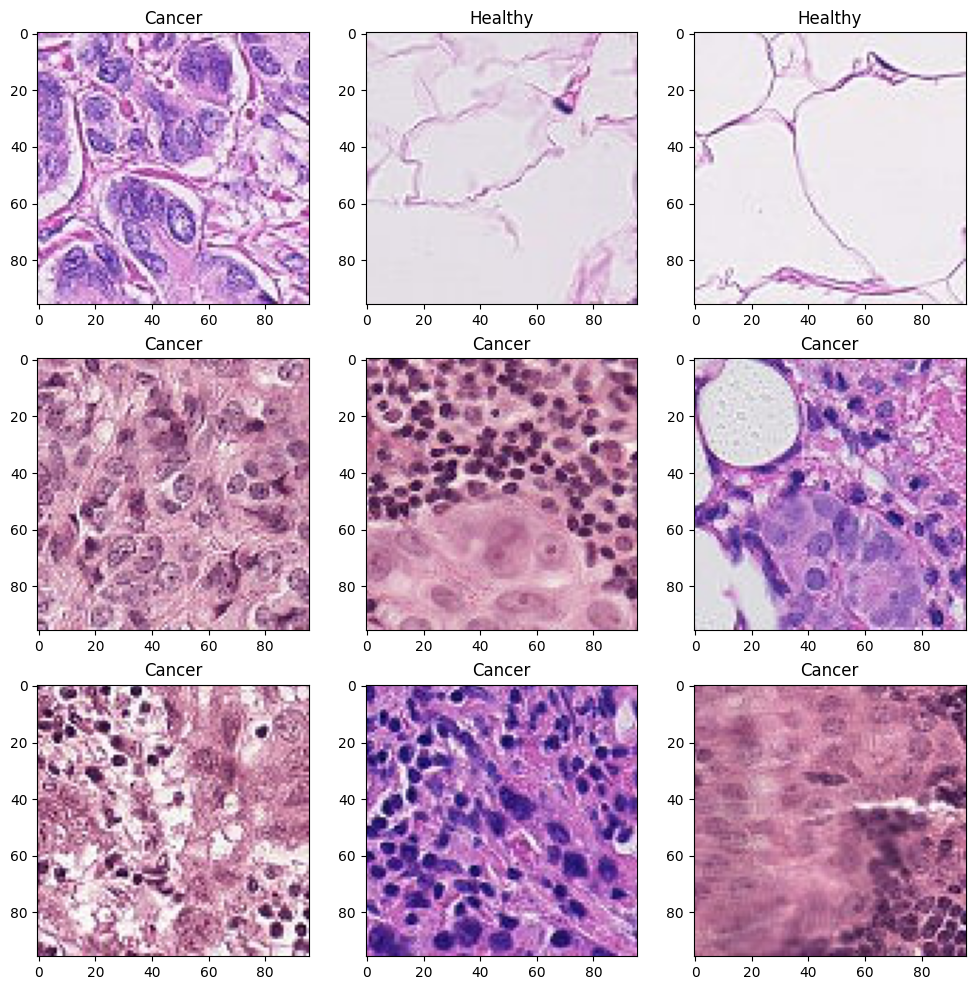

In [51]:
# Plotting 9 random samples with their respective layers
f,axes = plt.subplots(3,3)
f.set_size_inches([12,12])
axes = axes.ravel()
for i_ax, i in enumerate(np.round(np.random.sample(9)*df_training_labels.shape[0])):
    i = int(i)
    print(i)
    im = Image.open( f'{PATH_TRAINING}/{df_training_labels.id[i]}')
    axes[i_ax].imshow(im)
    print(type(df_training_labels.label[i]))
    if df_training_labels.label[i] == '1':
        axes[i_ax].set_title('Cancer')
    else:
        axes[i_ax].set_title('Healthy')
        


In [52]:
batch_size, im_size = 256, (64,64)
generator = ImageDataGenerator(rescale=1./255, validation_split=0.25)
training_data_gen = generator.flow_from_dataframe(
    dataframe = df_training_labels,
    x_col='id', 
    y_col='label', 
    directory=PATH_TRAINING,
    subset='training',
    class_mode='binary',
    batch_size=batch_size,
    target_size=im_size)
 
validation_data_gen = generator.flow_from_dataframe(
    dataframe=df_training_labels,
    x_col='id', 
    y_col='label', 
    directory=PATH_TRAINING,
    subset="validation",
    class_mode='binary',
    batch_size=batch_size,
    target_size=im_size)
 

Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.


# DModel Architecture
This architecture is a convolutional neural net consisting of two convolutional net blocks with a MaxPool2D layer to reduce dimensionality after each block. Finally we connect the output of our convolutional network to a fully dense layer with a hidden layer of 256 neurons and a final output layer. The output layer is a single neuron with a sigmoid function, everything else utilizes relu.

 Based on the information from the course and historical evidence in the contest, a simple convolutional neural net should be sufficient to learn the patterns within this dataset. 

We also include a second neural net that uses Average instead of Maxpool, and also includes dropout at the end

In [53]:
model1 = keras.Sequential()

model1.add( Conv2D(16, (3,3), activation='relu',  input_shape=(im_size[0], im_size[1], 3)) )
model1.add( Conv2D(16, (3,3), activation='relu') )
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add( Conv2D(32, (3,3), activation='relu') )
model1.add( Conv2D(32, (3,3), activation='relu') )
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.build(input_shape=(batch_size,im_size[0],im_size[1],3))
model1.summary()


opt = Adam(learning_rate=0.0001)
model1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
hist = model1.fit(training_data_gen, validation_data=validation_data_gen, epochs=10)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 conv2d_83 (Conv2D)          (None, 60, 60, 16)        2320      
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 30, 30, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_84 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 conv2d_85 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                               

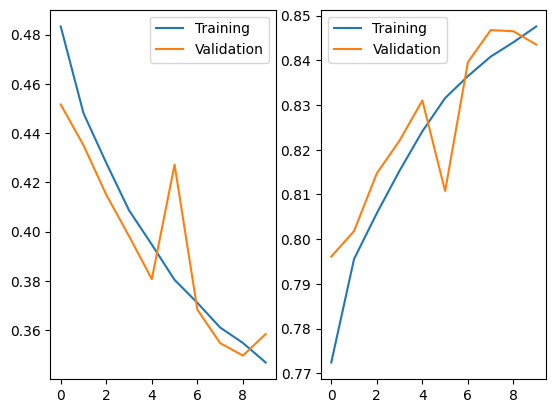

In [61]:
f, axes = plt.subplots(1,2)


axes[0].plot(hist.history['loss'], label='Training')
axes[0].plot(hist.history['val_loss'], label='Validation')
axes[0].legend()

axes[1].plot(hist.history['accuracy'], label='Training')
axes[1].plot(hist.history['val_accuracy'], label='Validation')
axes[1].legend()

In [63]:
model2 = keras.Sequential()

model2.add( Conv2D(16, (3,3), activation='relu',  input_shape=(im_size[0], im_size[1], 3)) )
model2.add( Conv2D(16, (3,3), activation='relu') )
model2.add(AveragePooling2D(pool_size=(2,2)))

model2.add( Conv2D(32, (3,3), activation='relu') )
model2.add( Conv2D(32, (3,3), activation='relu') )
model2.add(AveragePooling2D(pool_size=(2,2)))

model2.add(Flatten())

model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation='sigmoid'))

model2.build(input_shape=(batch_size,im_size[0],im_size[1],3))
model2.summary()

opt = RMSprop(learning_rate=0.0001)
model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
hist2 = model2.fit(training_data_gen, validation_data=validation_data_gen, epochs=10)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_86 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 conv2d_87 (Conv2D)          (None, 60, 60, 16)        2320      
                                                                 
 average_pooling2d (Average  (None, 30, 30, 16)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_88 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 conv2d_89 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 average_pooling2d_1 (Avera  (None, 13, 13, 32)        0         
 gePooling2D)                                        

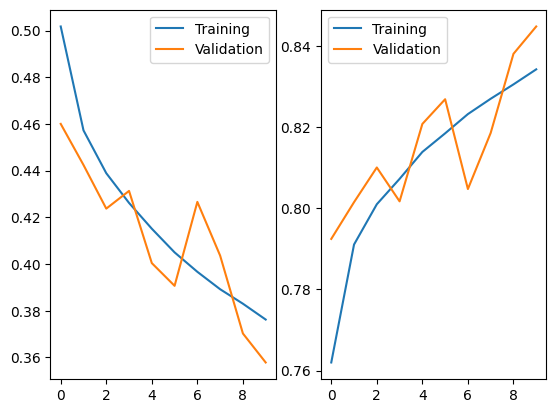

In [64]:
f, axes = plt.subplots(1,2)


axes[0].plot(hist2.history['loss'], label='Training')
axes[0].plot(hist2.history['val_loss'], label='Validation')
axes[0].legend()

axes[1].plot(hist2.history['accuracy'], label='Training')
axes[1].plot(hist2.history['val_accuracy'], label='Validation')
axes[1].legend()

In [25]:

test_data = pd.DataFrame({'id': [d for d in os.listdir(PATH_TEST) if '.DS_store' not in d] })
test_data_gen = ImageDataGenerator(rescale=1./255) 
 
test_data = test_data_gen.flow_from_dataframe(
    dataframe = test_data,
    x_col='id', 
    directory=PATH_TEST,
    class_mode=None,
    batch_size=1,
    target_size=im_size,
    shuffle=False)
 
# predict with the model
predictions = model1.predict(test_data, verbose=1)
predictions = predictions.squeeze()
predictions.shape
 
# create submission dataframe for kaggle submission
df_submission = pd.DataFrame()
df_submission['id'] = test_data['id'].apply(lambda x: x.split('.')[0])
df_submission['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
df_submission['label'].value_counts()
df_submission.to_csv('submission2.csv', index=False)
print(df_submission.head())
 

Found 57458 validated image filenames.
57458/57458 [==============================] - 98s 2ms/step
                                         id  label
0  fd0a060ef9c30c9a83f6b4bfb568db74b099154d      1
1  1f9ee06f06d329eb7902a2e03ab3835dd0484581      1
2  19709bec800f372d0b1d085da6933dd3ef108846      1
3  7a34fc34523063f13f0617f7518a0330f6187bd3      0
4  93be720ca2b95fe2126cf2e1ed752bd759e9b0ed      0
